In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [2]:
df=pd.read_csv('DM2425_ABCDEats_DATASET.csv',delimiter=',')

# Drop Dublicates

We need to eliminate duplicates to prevent further issues, especially with the index setting

In [3]:
df.duplicated().sum()

np.int64(13)

In [4]:
df=df.drop_duplicates()
# Count the number of remaining duplicate rows in the DataFrame after dropping duplicates
df.duplicated().sum()

np.int64(0)

# Set costumer_id as the index

In [5]:
df.set_index('customer_id', inplace=True)

## Fixing variables

**customer_age**

Fill missing values with median

In [6]:
df['customer_age'].isna().sum()

np.int64(727)

In [7]:
df['customer_age'] = df['customer_age'].fillna(df['customer_age'].median())
df['customer_age'].isna().sum()

np.int64(0)

**costumer_region**

Replace the value of '-' with 'Unknown' to enhance the interpretation of the feature

In [8]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('8550', '-')

In [9]:
df.loc[:, 'customer_region'] = df['customer_region'].replace('-', np.nan)

In [10]:
mode_value = df['customer_region'].mode()[0]
df['customer_region'] = df['customer_region'].fillna(mode_value)

In [11]:
df['customer_region'].value_counts()

customer_region
8670    10216
4660     9550
2360     8829
2440     1483
4140      857
8370      495
2490      445
Name: count, dtype: int64

**product_count**

There is an extreme product count value with '92ced2dcb9' index, so we will transform it into a high value

In [12]:
df.loc['92ced2dcb9','product_count']=100

**first_order**

Fill missing values with median

In [13]:
df['first_order'] = df['first_order'].fillna(df['first_order'].median())

**last_promo**

Replace the value of '-' with 'no_promotion_used' to enhance the interpretation of the feature

In [14]:
df['last_promo'] = df['last_promo'].replace('-', 'no_promotion_used')

**HR_0**

Drop the column labeled "HR_0" because it contains only zeros.

In [15]:
df.drop(columns=['HR_0'], inplace=True)

#Fixing inconsistencies

Eliminate rows where there are inconsistencies

In [16]:
df['sum_HR']=df['HR_1']+df['HR_2']+df['HR_3']+df['HR_4']+df['HR_5']+df['HR_6']+df['HR_7']+df['HR_8']+df['HR_9']+df['HR_10']+df['HR_11']+df['HR_12']+df['HR_13']+df['HR_14']+df['HR_15']+df['HR_16']+df['HR_17']+df['HR_18']+df['HR_19']+df['HR_20']+df['HR_21']+df['HR_22']+df['HR_23']
df['sum_DOW']=df['DOW_0']+df['DOW_1']+df['DOW_2']+df['DOW_3']+df['DOW_4']+df['DOW_5']+df['DOW_6']
df['inc_0']=(df['sum_HR']!=df['sum_DOW'])
df['inc_2']=(df['product_count']==0)
df = df.loc[~(df['inc_0'] | df['inc_2'])]
df = df.drop(columns=['sum_HR', 'sum_DOW', 'inc_0', 'inc_2'])

# New variables

**Total_Spent**

In [17]:
cuisine = [col for col in df.columns if col.startswith('CUI_')]

In [18]:
df['Total_Spent']=df[cuisine].sum(axis=1)

Deal with extreme outliers

In [19]:
df = df.drop('92ced2dcb9', axis=0)
df.loc['249ba584d3','CUI_Asian']=500
df.loc['8d65421423','CUI_Japanese']=590
df['Total_Spent']=df[cuisine].sum(axis=1)

**Order_Count**

In [20]:
df['order_count']=df['DOW_0']+df['DOW_1']+df['DOW_2']+df['DOW_3']+df['DOW_4']+df['DOW_5']+df['DOW_6']

**Diversity_Cuisine**

In [21]:
df['Diversity_Cuisine'] = (df[cuisine] > 0).sum(axis=1)
df['Diversity_Cuisine'] = df['order_count']/df['Diversity_Cuisine']

**Costumer_time**

In [22]:
df['costumer_time']=df['last_order']-df['first_order']

**Intensity_of_Activity**

In [23]:
df['Intensity_of_Activity'] = df['costumer_time'] / df['order_count']

**Customer_Loyalty**

In [24]:
df['Customer_loyalty'] = df['vendor_count'] / df['order_count']

**Product_Intensity**

In [25]:
df['product_intensity'] = df['product_count'] / df['order_count']

**Day_Week_Spread**

In [26]:
days = [col for col in df.columns if col.startswith('DOW_')]

In [27]:
df['Day_Week_Spread'] = df.loc[:,days].var(axis=1)

**hour_spread**

In [28]:
hours=[col for col in df.columns if col.startswith('HR_')]

In [29]:
df['hour_spread'] = df.loc[:,hours].var(axis=1)

In [30]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_1', 'HR_2', 'HR_3',
       'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11',
       'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19',
       'HR_20', 'HR_21', 'HR_22', 'HR_23', 'Total_Spent', 'order_count',
       'Diversity_Cuisine', 'costumer_time', 'Intensity_of_Activity',
       'Customer_loyalty', 'product_intensity', 'Day_Week_Spread',
       'hour_spread'],
      dtype='object')

# Normalize data

In [31]:
#Select numeric features
metric_features = df.select_dtypes(include=['number']).columns.tolist()

In [32]:
# Normalize numeric data with Min-Max scaler
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df[metric_features])
df[metric_features] = scaled_feat

# Separate data by  demographic,psychographic and behaviour-based segmentation

In [33]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_1', 'HR_2', 'HR_3',
       'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11',
       'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19',
       'HR_20', 'HR_21', 'HR_22', 'HR_23', 'Total_Spent', 'order_count',
       'Diversity_Cuisine', 'costumer_time', 'Intensity_of_Activity',
       'Customer_loyalty', 'product_intensity', 'Day_Week_Spread',
       'hour_spread'],
      dtype='object')

In [34]:
df.drop('customer_region',axis=1,inplace=True)
df.drop('payment_method',axis=1,inplace=True)
df.drop('last_promo',axis=1,inplace=True)


In [35]:
df_demo=df['customer_age']

In [36]:
df = df.drop('customer_age', axis=1)

In [37]:
cuisine_columns=[col for col in df.columns if col.startswith('CUI')]

In [38]:
df_psy=df[cuisine_columns]

In [39]:
df.drop(cuisine_columns,axis=1,inplace=True)

In [40]:
df_behavi=df.copy()

# PCA analisys psychographic segmentation

In [41]:
pca = PCA().fit(df_psy)

In [42]:
PCA_s=pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)
PCA_s.head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,0.001935,0.000000,0.169510,0.169510
2,0.001672,-0.000263,0.146510,0.316020
3,0.001310,-0.000362,0.114816,0.430836
4,0.001254,-0.000056,0.109882,0.540718
5,0.001082,-0.000172,0.094807,0.635525
6,0.000714,-0.000369,0.062514,0.698039
7,0.000569,-0.000145,0.049844,0.747883
8,0.000553,-0.000016,0.048415,0.796298
9,0.000513,-0.000040,0.044922,0.841220
10,0.000476,-0.000037,0.041717,0.882937


In [43]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=df_psy.columns)
print(loadings)

                               PC1       PC2       PC3       PC4       PC5  \
CUI_American              0.437491  0.836006  0.101510  0.171789 -0.227643   
CUI_Asian                 0.697184 -0.182693 -0.452639 -0.512606  0.059351   
CUI_Beverages             0.208897 -0.189561 -0.497612  0.810293  0.074062   
CUI_Cafe                  0.011127  0.085022 -0.007428 -0.009926  0.103758   
CUI_Chicken Dishes       -0.026392  0.017320 -0.011902  0.017425  0.057071   
CUI_Chinese               0.006611  0.003435 -0.019056  0.010352  0.021889   
CUI_Desserts              0.084087 -0.041656 -0.008958  0.037564 -0.007314   
CUI_Healthy               0.020305  0.020618 -0.021976 -0.013095  0.070504   
CUI_Indian               -0.028881  0.073464 -0.010317 -0.025291  0.117862   
CUI_Italian              -0.035422  0.139572  0.034362 -0.027219  0.082847   
CUI_Japanese              0.035974  0.021608 -0.011728 -0.018487  0.041476   
CUI_Noodle Dishes        -0.021521  0.000631 -0.012879  0.019757

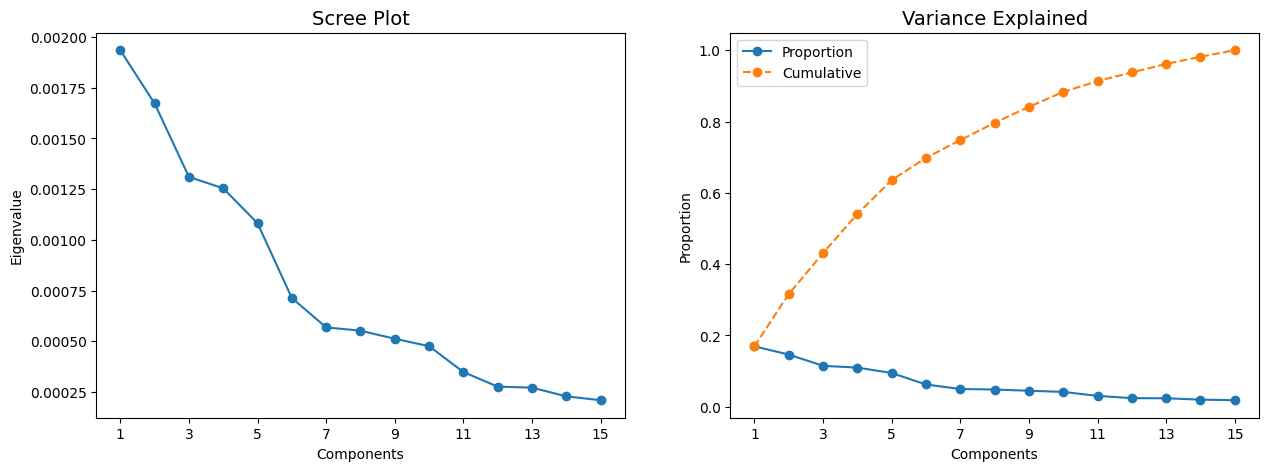

In [44]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

We decided to establish a threshold of 85% cumulative variance, so we will retain the first 10 components

In [45]:
#Retain the first 8 components
pca = PCA(n_components=10)
pca_feat = pca.fit_transform(df_psy)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
#Create the dataframe "df_PCA" with the PC`s and the normalized categorical features
df_PCA = pd.DataFrame(pca_feat, index=df_psy.index, columns=pca_feat_names)
#Normalize the PC features
metric_features1 = df_PCA.select_dtypes(include=['number']).columns.tolist()
scaled_feat = scaler.fit_transform(df_PCA)
df_PCA = scaled_feat
df_psy = pd.DataFrame(df_PCA, index=df_psy.index, columns=metric_features1)

# PCA Behavioral segmentation

In [46]:
pca = PCA().fit(df_behavi)

In [47]:
PCA_s=pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)
PCA_s.head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,0.157822,0.000000,0.437967,0.437967
2,0.085731,-0.072092,0.237908,0.675874
3,0.043911,-0.041820,0.121855,0.797730
4,0.020427,-0.023484,0.056686,0.854416
5,0.007456,-0.012971,0.020690,0.875106
6,0.003983,-0.003473,0.011052,0.886158
7,0.003596,-0.000387,0.009978,0.896136
8,0.003113,-0.000483,0.008639,0.904775
9,0.002866,-0.000247,0.007953,0.912728
10,0.002490,-0.000376,0.006909,0.919637


In [48]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=df_behavi.columns)
print(loadings)

                            PC1       PC2       PC3       PC4       PC5  \
vendor_count           0.103712  0.007055  0.034203 -0.322336 -0.058883   
product_count          0.095506  0.009141 -0.065172 -0.263773  0.057768   
is_chain               0.067807  0.003522 -0.039534 -0.193427 -0.073564   
first_order           -0.447190  0.690492 -0.144535 -0.023662 -0.004327   
last_order             0.359488  0.719627  0.201740  0.022304  0.000488   
DOW_0                  0.071627  0.004180 -0.050118 -0.195270 -0.047383   
DOW_1                  0.069781  0.005958 -0.051272 -0.191290 -0.040915   
DOW_2                  0.082755  0.008709 -0.060925 -0.217131 -0.046452   
DOW_3                  0.074900  0.011344 -0.054296 -0.190893 -0.044125   
DOW_4                  0.080798  0.014964 -0.061556 -0.199671 -0.040790   
DOW_5                  0.055800  0.004912 -0.034298 -0.144437 -0.023956   
DOW_6                  0.075940 -0.000644 -0.046038 -0.191291 -0.023271   
HR_1                   0.

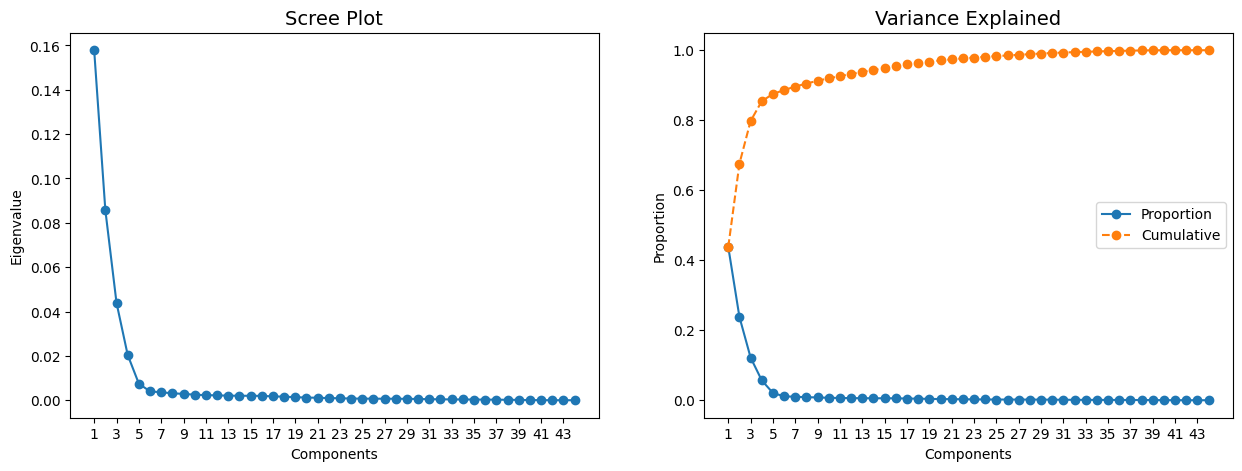

In [49]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

We decided to establish a threshold of 85% cumulative variance, so we will retain the first 5 components

In [50]:
#Retain the first 5 components
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(df_behavi)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
#Create the dataframe "df_PCA" with the PC`s and the normalized categorical features
df_PCA = pd.DataFrame(pca_feat, index=df_behavi.index, columns=pca_feat_names)
#Normalize the PC features
metric_features1 = df_PCA.select_dtypes(include=['number']).columns.tolist()
scaled_feat = scaler.fit_transform(df_PCA)
df_PCA = scaled_feat
df_behavi = pd.DataFrame(df_PCA, index=df_behavi.index, columns=metric_features1)

# Outlier removing using DBSCAN

In psychographic segmentation

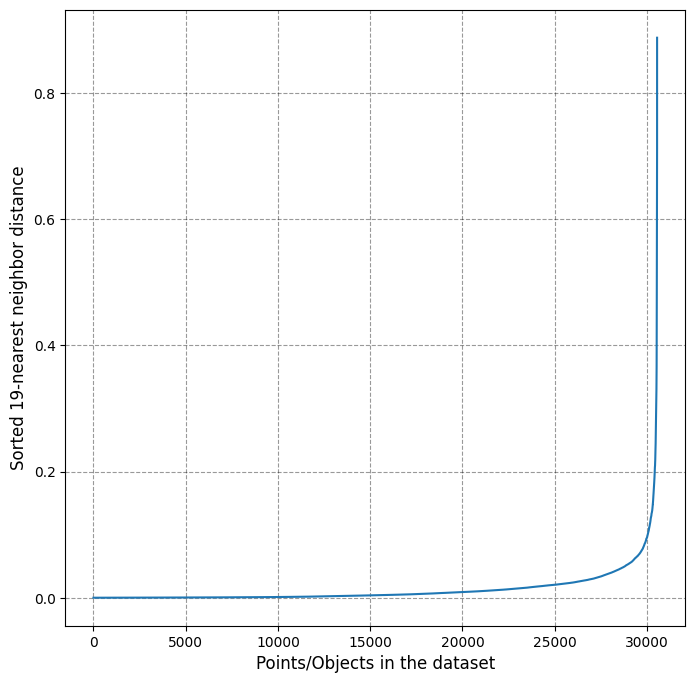

In [51]:
from sklearn.neighbors import NearestNeighbors
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * df_psy.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=df_psy, k=k)

In [52]:
from sklearn.cluster import DBSCAN
epsilon = 0.05  
min_samples = 21  
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(df_psy)
df_psy['Cluster'] = clusters
df_psy['Cluster'].value_counts()

Cluster
 0    29489
-1     1065
Name: count, dtype: int64

In [53]:
df_psy = df_psy[df_psy['Cluster'] != -1].reset_index(drop=True)
df_psy=df_psy.drop('Cluster',axis=1)

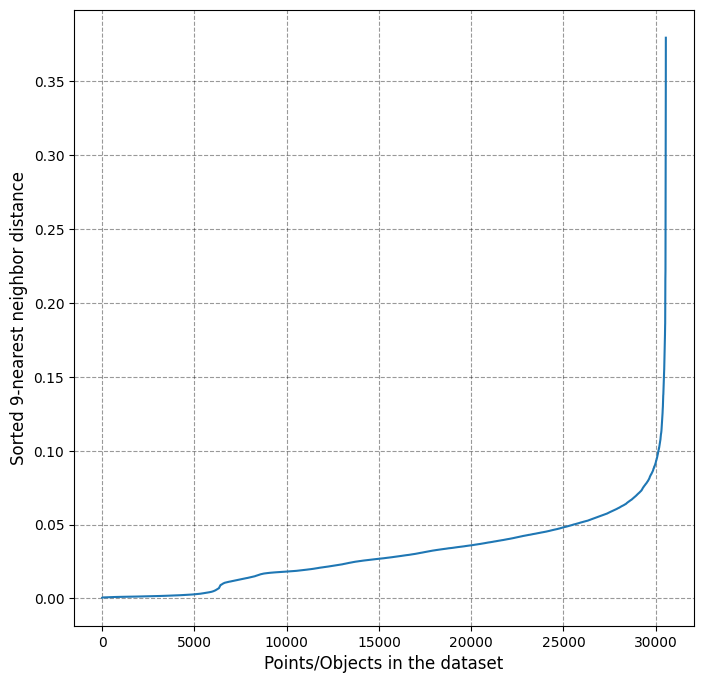

In [54]:
from sklearn.neighbors import NearestNeighbors
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * df_behavi.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=df_behavi, k=k)

In [55]:
from sklearn.cluster import DBSCAN
epsilon = 0.06  
min_samples = 11  
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(df_behavi)
df_behavi['Cluster'] = clusters
df_behavi['Cluster'].value_counts()

Cluster
 0    28491
-1     1651
 1      247
 8       80
 9       23
 6       12
 7       12
 5       11
 3       11
 4        9
 2        7
Name: count, dtype: int64

In [56]:
df_behavi = df_behavi[df_behavi['Cluster'] != -1].reset_index(drop=True)
df_behavi=df_behavi.drop('Cluster',axis=1)

# Output data

In [57]:
df_behavi.to_csv('df_behaviour.csv')

In [58]:
df_psy.to_csv('df_psy.csv')

In [59]:
df_demo.to_csv('df_demo.csv')